#**Self-Supervised Contrastive Learning for Gene-Image Interpretability**

## **Setup**

In [ ]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms

from captum.attr import IntegratedGradients

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.decomposition import PCA

from tqdm.notebook import tqdm

from google.colab import drive
import zipfile
import copy

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
drive.mount('/content/drive/')
# zip_ref = zipfile.ZipFile("/content/drive/My Drive/harvard/6.7930/data/archive.zip", 'r')
# zip_ref.extractall("/content/drive/My Drive/harvard/6.7930/data/kaggle_mri/")
# zip_ref.close()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.FloatTensor)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **Utils**

In [ ]:
class ImageGenoDataset(Dataset):
    def __init__(self, images, modes, targets, transform):
        """
        images -- Batch size # of images
        snps -- SNP genotype matrix (0, 1, 2); (batch_size, num_genes)
        """
        self.images = images.type(torch.FloatTensor)
        self.modes = [mode.type(torch.FloatTensor) for mode in modes]
        self.targets = targets.type(torch.FloatTensor)
        self.transform = transform

    def __getitem__(self, index): 
        sample = self.images[index]
        modes = [mode[index] for mode in self.modes]
        target = self.targets[index]
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, modes, target
    
    def __len__(self):
        return len(self.images)

## **Synthetic Genetic Correlations**

In [ ]:
# get images
data_dir = "/content/drive/My Drive/harvard/6.7930/data/kaggle_mri/Training"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
mri_dataset = datasets.ImageFolder(data_dir, transform = transform)
mri_dataloader = DataLoader(mri_dataset, batch_size = 1, shuffle = False)

In [ ]:
mri_dataset.class_to_idx

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [ ]:
len(np.unique(mri_dataset.classes))

4

In [ ]:
def simulate_genotype(label):
    
    snps = ['sim_rs' + str(i) for i in range(500)]
    
    geno = [0] * len(snps)

    if label == 0:
        geno[0:50] = np.random.choice([0, 1, 2], size = 50, p = [0.05, 0.05, 0.9]) # modified
        geno[50:] = np.random.choice([0, 1, 2], size = 450, p = [0.25, 0.55, 0.2]) # standard
    elif label == 1:
        geno[:50] = np.random.choice([0, 1, 2], size = 50, p = [0.25, 0.55, 0.2])
        geno[50:100] = np.random.choice([0, 1, 2], size = 50, p = [0.05, 0.05, 0.9])
        geno[100:] = np.random.choice([0, 1, 2], size = 400, p = [0.25, 0.55, 0.2])
    elif label == 2:
        geno[:100] = np.random.choice([0, 1, 2], size = 100, p = [0.25, 0.55, 0.2])
        geno[100:150] = np.random.choice([0, 1, 2], size = 50, p = [0.05, 0.05, 0.9])
        geno[150:] = np.random.choice([0, 1, 2], size = 350, p = [0.25, 0.55, 0.2])
    else:
        geno[:150] = np.random.choice([0, 1, 2], size = 150, p = [0.25, 0.55, 0.2])
        geno[150:200] = np.random.choice([0, 1, 2], size = 50, p = [0.05, 0.05, 0.9])
        geno[200:] = np.random.choice([0, 1, 2], size = 300, p = [0.25, 0.55, 0.2])

    return geno

In [ ]:
# build a preloaded dataset (possible b/c small images)
genos = []
targets = []
mri_dataloader = DataLoader(mri_dataset, batch_size = 1, shuffle = False)
for x, y in tqdm(mri_dataloader):
    # images = torch.cat([images, x])
    sim_geno = torch.tensor(simulate_genotype(y))
    # print(sim_geno.unsqueeze(0).shape, genos.shape)
    genos.append(sim_geno.unsqueeze(0))
    targets.append(y)
genos = torch.cat(genos).to(device)
targets = torch.cat(targets).to(device)

# so we can get images more efficiently
images = []
targets_copy = []
mri_dataloader = DataLoader(mri_dataset, batch_size = 512, shuffle = False)
for x, y in tqdm(mri_dataloader):
    images.append(x)
    targets_copy.append(y)
images = torch.cat(images).to(device) 
targets_copy = torch.cat(targets_copy).to(device)

print(images.shape, genos.shape, targets.shape) 
print((targets == targets_copy).all()) # make sure same ordering

  0%|          | 0/2870 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([2870, 3, 224, 224]) torch.Size([2870, 500]) torch.Size([2870])
tensor(True, device='cuda:0')


## **Models**

### **Classes**

In [ ]:
class ResnetEncoder(nn.Module):
    """
    ResNet18 feature extractor
    """
    def __init__(self, num_channels, num_classes, weights = None, out_dim=20):
        super(ResnetEncoder, self).__init__()
        self.resnet = resnet18(weights = weights)#'IMAGENET1K_V2') # finetuning
        # self.resnet.conv1 = nn.Conv2d(num_channels, 64, 7, stride=2, padding=3, bias=False)
        self.feature_extractor = torch.nn.Sequential(*list(self.resnet.children())[:-1])
        self.out = nn.Linear(512, out_dim)

    def forward(self, x):
        """
        """
        # print(x.shape)
        z = self.feature_extractor(x).squeeze((-2, -1))
        # print(z.shape)
        z = self.out(z)
        z = F.normalize(z, dim = 1)
        return z

class Squeeze(nn.Module): # for classifier
    def forward(self, x):
        return x.squeeze((-2, -1))

class SNPEncoder(nn.Module):
    """
    MLP
    """
    def __init__(self, x_dim, out_dim, fc_dims, use_bn = True):
        """
            fc_dims -- A list of fully connected layers
            p -- Dropout
        """
        super(SNPEncoder, self).__init__()
        self.x_dim = x_dim
        self.use_bn = use_bn
        self.enc_shape = fc_dims
        self.enc = []
        for i in range(len(self.enc_shape)):
            if i == 0: # set intial data fc from x -> i
                self.enc.append(nn.Linear(self.x_dim, self.enc_shape[i]))
            else: # fc from i-1 -> i
                self.enc.append(nn.Linear(self.enc_shape[i-1], self.enc_shape[i]))

            if self.use_bn:
                self.enc.append(nn.BatchNorm1d(self.enc_shape[i]))
        self.enc = nn.ModuleList(self.enc)
        self.out = nn.Linear(fc_dims[-1], out_dim)

    def forward(self, x):
        # encode x's until shared layer
        for l in self.enc:
            x = l(x)
            if isinstance(l, nn.BatchNorm1d):
                x = F.relu(x) 
        z = self.out(x)
        z = F.normalize(z, dim = 1)
        
        return z

class MultimodalNet(nn.Module):
    def __init__(self, img_enc, img_kwargs, mode_encs, mode_kwargs, latent_dim = 20, p = 0.3, device = 'cpu'):
        """
        Multimodal network combining image encoder with other modalities

            img_enc -- Image encoder
            mode_encs -- List of models encoding each modality
            mode_kwargs -- List of parameter dictionaries for each modality encoder
                mode_kwargs should not have an out_dim key, but every model should have 
                an out_dim argument
            latent_dim -- Dimension of shared latent space
        """
        super(MultimodalNet, self).__init__()
        self.im_model = img_enc(**img_kwargs, out_dim = latent_dim).to(device)
        self.model = []
        for i in range(len(mode_encs)):
            self.model.append(mode_encs[i](**mode_kwargs[i], out_dim = latent_dim).to(device))

    def forward(self, im, modes):
        """
            im -- image tensor (batch_size x ...)
            modes -- list of mode batch tensors
        """
        z_im = self.im_model(im)
        z_modes = []
        for i in range(len(modes)):
            z_modes.append(self.model[i](modes[i]))
        
        return z_im, z_modes

In [ ]:
LARGE_NUM = 1e9

class NTXentLoss(torch.nn.Module):
    """
    Cross-modal self-supervised contrastive loss
        https://github.com/HealthML/ContIG/blob/main/models/cross_modal_loss.py
    """
    def __init__(self, device, batch_size, temperature, alpha_weight):
        """Compute loss for model.
        temperature: a `floating` number for temperature scaling.
        weights: a weighting number or vector.
        """
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.alpha_weight = alpha_weight
        self.device = device
        self.softmax = torch.nn.Softmax(dim=-1)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    def softXEnt(self, target, logits):
        """
        From the pytorch discussion Forum:
            https://discuss.pytorch.org/t/soft-cross-entropy-loss-tf-has-it-does-pytorch-have-it/69501
        """
        logprobs = torch.nn.functional.log_softmax(logits, dim=1)
        loss = -(target * logprobs).sum() / logits.shape[0]
        return loss

    def forward(self, zis, zjs, norm=True):
        temperature = self.temperature
        alpha = self.alpha_weight

        # Get (normalized) hidden1 and hidden2.
        if norm:
            zis = F.normalize(zis, p=2, dim=1)
            zjs = F.normalize(zjs, p=2, dim=1)

        hidden1, hidden2 = zis, zjs
        batch_size = hidden1.shape[0]

        hidden1_large = hidden1
        hidden2_large = hidden2
        labels = F.one_hot(
            torch.arange(start=0, end=batch_size, dtype=torch.int64),
            num_classes=batch_size,
        ).float()
        labels = labels.to(self.device)

        # Different from Image-Image contrastive learning
        # In the case of Image-Gen contrastive learning we do not compute the intra-modal similarity
        # masks = F.one_hot(
        #     torch.arange(start=0, end=batch_size, dtype=torch.int64),
        #     num_classes=batch_size,
        # )
        # logits_aa = torch.matmul(hidden1, torch.transpose(hidden1_large,0, 1)) / temperature
        # logits_aa = logits_aa - masks * LARGE_NUM
        # logits_bb = torch.matmul(hidden2,  torch.transpose(hidden2_large,0, 1)) / temperature
        # logits_bb = logits_bb - masks * LARGE_NUM

        logits_ab = (
            torch.matmul(hidden1, torch.transpose(hidden2_large, 0, 1)) / temperature
        )
        logits_ba = (
            torch.matmul(hidden2, torch.transpose(hidden1_large, 0, 1)) / temperature
        )

        loss_a = self.softXEnt(labels, logits_ab)
        loss_b = self.softXEnt(labels, logits_ba)

        return alpha * loss_a + (1 - alpha) * loss_b + F.mse_loss(logits_ab, logits_ba) # add that the logits should be the same?

## **Training**

In [ ]:
def epoch_contrastive(model, criterion, loader, epoch, 
                       w = 1, optimizer = None, device = 'cpu'):
    """
    standard contrastive epoch
    """
    # print(criterion)
    if optimizer:
        model.train()
        mode = 'Train'
    else:
        model.eval()
        mode = 'Val'

    train_loss = []
    batches = tqdm(enumerate(loader), total=len(loader))
    batches.set_description("Epoch NA: Loss (NA)")

    for batch_idx, (im, modes, y) in batches:
        im, modes, y = im.to(device), [mode.to(device) for mode in modes], y.to(device)
        z_im, z_modes = model(im, modes)
        loss = 0
        for z_mode in z_modes:
            loss = loss + w * criterion(z_im, z_mode)#, y.to(torch.int64))
            
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(loss.item())
        batches.set_description(
            "Epoch {:d}: {:s} Loss ({:.2e})".format(
                epoch, mode, loss.item()
            )
        )

    return np.mean(train_loss)

def epoch_standard(model, criterion, loader, epoch, optimizer = None, device = 'cpu'):
    """
    standard epoch
    """
    if optimizer:
        model.train()
        mode = 'Train'
    else:
        model.eval()
        mode = 'Val'

    train_loss = []
    batches = tqdm(enumerate(loader), total=len(loader))
    batches.set_description("Epoch NA: Loss (NA) ACC (NA)")

    count = 0
    correct = 0

    for batch_idx, (x, _, y) in batches:
        x, y = x.to(device), y.to(device)
        z = model(x)
        # print(z.shape, y.shape, type(z), type(y))
        loss = F.cross_entropy(z, y.to(torch.int64)) # criterion isnt working??
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        correct += (z.max(axis = 1).indices == y).float().sum()
        count += y.shape[0]

        train_loss.append(loss.item())
        batches.set_description(
            "Epoch {:d}: {:s} Loss ({:.2e}) ACC ({:.2e})".format(
                epoch, mode, loss.item(), 100 * correct / count
            )
        )

    return np.mean(train_loss), (100 * correct/count).detach().cpu().numpy()


### **Data Setup**

In [ ]:
ig_dataset = ImageGenoDataset(images, [genos], targets, transform = None)
TRAIN_SIZE = int(len(ig_dataset) * 0.7)
VAL_SIZE = int(len(ig_dataset) * 0.15)
TEST_SIZE = len(ig_dataset) - TRAIN_SIZE - VAL_SIZE
train_dataset, val_dataset, test_dataset = random_split(ig_dataset, [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
for im, geno, y in train_loader:
    print(im.shape, geno[0].shape, y.shape)
    break

torch.Size([128, 3, 224, 224]) torch.Size([128, 500]) torch.Size([128])


In [ ]:
targets.unique()

tensor([0, 1, 2, 3], device='cuda:0')

### **Contrastive**

In [ ]:
# define model
Z_DIM = 64
LR = 3e-3
num_classes = len(np.unique(ig_dataset.targets.detach().cpu().numpy()))
resnet_kwargs = {
    'num_channels' : 3,
    'num_classes' : num_classes,
    'weights' : None
}

snp_kwargs = {
    'x_dim' : geno[0].shape[1], 
    'fc_dims' : [200, 50],
    'use_bn' : True
}
encs = [SNPEncoder]
enc_kwargs = [snp_kwargs]
multi_model = MultimodalNet(ResnetEncoder, resnet_kwargs, 
                            encs, enc_kwargs,
                            latent_dim = Z_DIM,
                            device = device).to(device)
optimizer = optim.AdamW(multi_model.parameters(), lr = LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
criterion_cl = NTXentLoss(device, 
                          BATCH_SIZE, 
                          temperature = 0.07, 
                          alpha_weight = 0.5) # 0.75 weight towards images as in ContIG paper

In [ ]:
# fit model
NUM_EPOCHS = 50
###### Train Model ######
train_losses = []
val_losses = []
best_val = float("inf")
best_epoch = 0

for epoch in tqdm(range(NUM_EPOCHS)):

    # train 
    train_loss = epoch_contrastive(multi_model, criterion_cl, train_loader, epoch, w = 1, optimizer = optimizer, device = device)
    train_losses.append(train_loss)

    # eval 
    val_loss = epoch_contrastive(multi_model, criterion_cl, val_loader, epoch, w = 1, optimizer = None, device = device)
    val_losses.append(val_loss)

    scheduler.step()

    # retain best val
    if best_val > val_losses[-1]:
        print(f"Updating at epoch {epoch}")
        best_val = val_losses[-1]
        best_epoch = epoch
        # save model parameter/state dictionary
        best_model = copy.deepcopy(multi_model.state_dict())

# load best weights
print(f"Best epoch at {best_epoch} with {'NTXent'} loss: {best_val}")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 0


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 2


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 3


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 4


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 5


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 6


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 7


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 8


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 9


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 10


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 11


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 12


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 13


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 14


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 15


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 16


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 18


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 20


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 21


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 22


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 23


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 24


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 25


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 26


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 28


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 29


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 31


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 32


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 38


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 41


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 45


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 47


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 48


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Best epoch at 48 with NTXent loss: 4.491688847541809


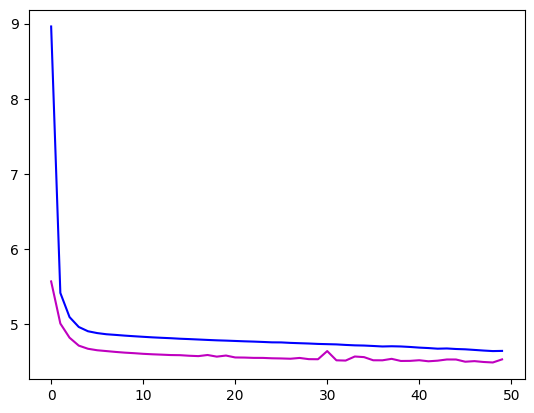

In [ ]:
plt.plot(list(range(NUM_EPOCHS)), train_losses, label='Training', c = 'b')
plt.plot(list(range(NUM_EPOCHS)), val_losses, label='Validation', c = 'm')

In [ ]:
multi_model.load_state_dict(best_model)

<All keys matched successfully>

In [ ]:
train_im = []
train_geno = []
train_y = []
for x, geno, y in tqdm(train_loader):
    z_im, z_geno = multi_model(x.to(device), [geno[0].to(device)])
    z_im, z_geno = z_im.detach().cpu(), [z_geno[0].detach().cpu()]
    train_im.append(z_im)
    train_geno.append(z_geno[0])
    train_y.append(y.detach().cpu())

train_im = torch.cat(train_im).numpy()
train_geno = torch.cat(train_geno).numpy()
train_y = torch.cat(train_y).numpy()

val_im = []
val_geno = []
val_y = []
for x, geno, y in tqdm(val_loader):
    z_im, z_geno = multi_model(x.to(device), [geno[0].to(device)])
    z_im, z_geno = z_im.detach().cpu(), [z_geno[0].detach().cpu()]
    val_im.append(z_im.detach().cpu())
    val_geno.append(z_geno[0].detach().cpu())
    val_y.append(y.to('cpu'))

val_im = torch.cat(val_im).detach().cpu().numpy()
val_geno = torch.cat(val_geno).detach().cpu().numpy()
val_y = torch.cat(val_y).detach().cpu().numpy()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

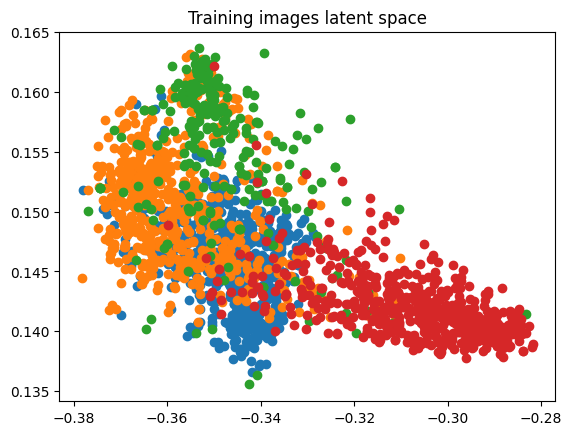

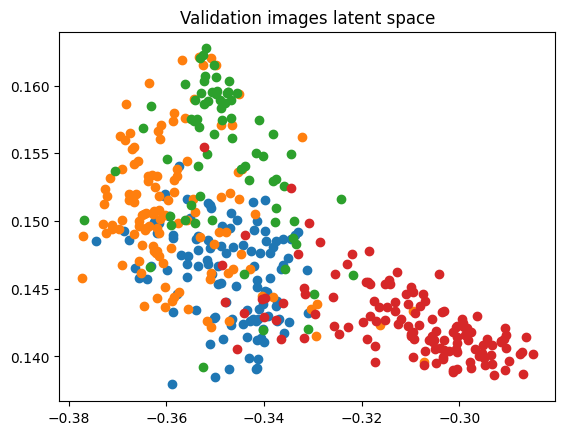

In [ ]:
im_pca = PCA()
im_pca.fit(train_im)
train_im_pcs = im_pca.transform(train_im) 
plt.scatter(train_im[train_y == 0][:, 0], train_im[train_y == 0][:, 1])
plt.scatter(train_im[train_y== 1][:, 0], train_im[train_y== 1][:, 1] )
plt.scatter(train_im[train_y== 2][:, 0], train_im[train_y== 2][:, 1] )
plt.scatter(train_im[train_y== 3][:, 0], train_im[train_y== 3][:, 1] )
plt.title("Training images latent space")
plt.show()


plt.scatter(val_im[val_y == 0][:, 0], val_im[val_y == 0][:, 1], label = 'Glioma Tumor')
plt.scatter(val_im[val_y== 1][:, 0], val_im[val_y== 1][:, 1] , label = 'Meningioma Tumor')
plt.scatter(val_im[val_y == 2][:, 0], val_im[val_y == 2][:, 1], label = 'No Tumor')
plt.scatter(val_im[val_y == 3][:, 0], val_im[val_y == 3][:, 1], label = 'Pituitary Tumor')
plt.title("Validation images latent space")
plt.show()

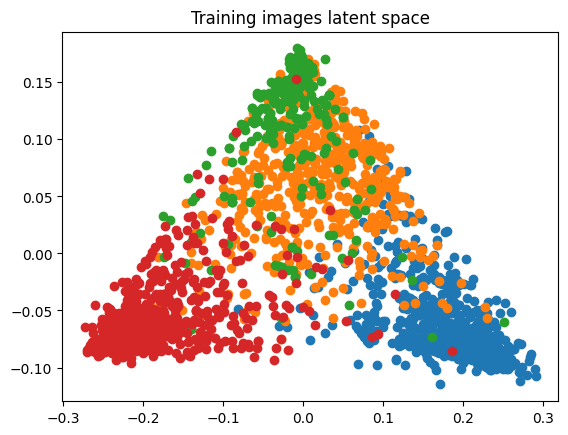

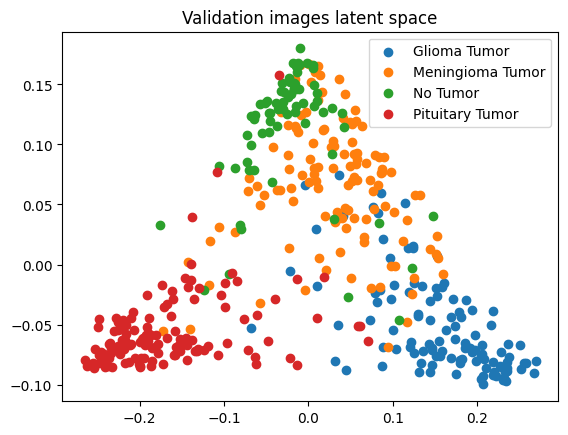

In [ ]:
# zoom in
im_pca = PCA()
im_pca.fit(train_im)
train_im_pcs = im_pca.transform(train_im) 
plt.scatter(train_im_pcs[train_y == 0][:, 0], train_im_pcs[train_y == 0][:, 1])
plt.scatter(train_im_pcs[train_y== 1][:, 0], train_im_pcs[train_y== 1][:, 1] )
plt.scatter(train_im_pcs[train_y== 2][:, 0], train_im_pcs[train_y== 2][:, 1] )
plt.scatter(train_im_pcs[train_y== 3][:, 0], train_im_pcs[train_y== 3][:, 1] )
plt.title("Training images latent space")
plt.show()

val_im_pcs = im_pca.transform(val_im)
plt.scatter(val_im_pcs[val_y == 0][:, 0], val_im_pcs[val_y == 0][:, 1], label = 'Glioma Tumor')
plt.scatter(val_im_pcs[val_y== 1][:, 0], val_im_pcs[val_y== 1][:, 1], label = 'Meningioma Tumor' )
plt.scatter(val_im_pcs[val_y == 2][:, 0], val_im_pcs[val_y == 2][:, 1], label = 'No Tumor')
plt.scatter(val_im_pcs[val_y == 3][:, 0], val_im_pcs[val_y == 3][:, 1], label = 'Pituitary Tumor')
plt.legend()
plt.title("Validation images latent space")
plt.show()

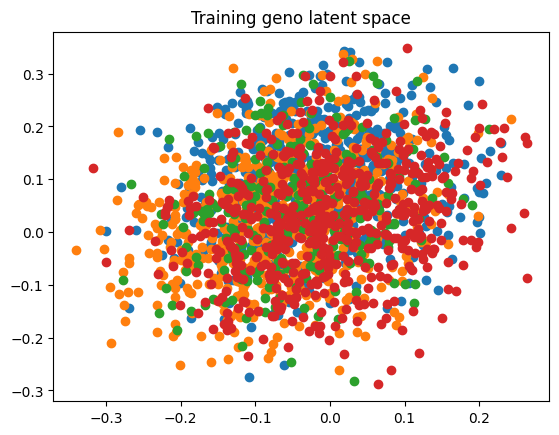

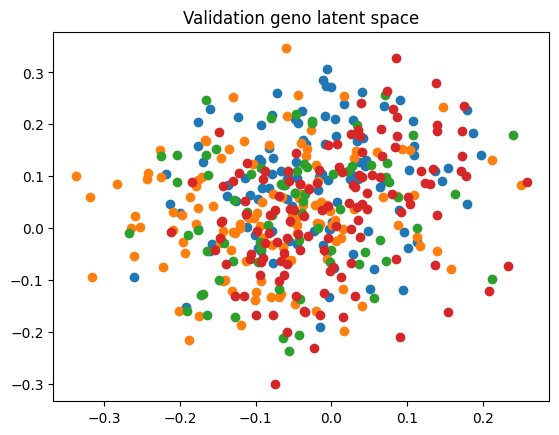

In [ ]:
im_pca = PCA()
im_pca.fit(train_im)
train_im_pcs = im_pca.transform(train_im) 
plt.scatter(train_geno[train_y == 0][:, 0], train_geno[train_y == 0][:, 1])
plt.scatter(train_geno[train_y== 1][:, 0], train_geno[train_y== 1][:, 1] )
plt.scatter(train_geno[train_y== 2][:, 0], train_geno[train_y== 2][:, 1] )
plt.scatter(train_geno[train_y== 3][:, 0], train_geno[train_y== 3][:, 1] )
plt.title("Training geno latent space")
plt.show()


plt.scatter(val_geno[val_y == 0][:, 0], val_geno[val_y == 0][:, 1])
plt.scatter(val_geno[val_y== 1][:, 0], val_geno[val_y== 1][:, 1] )
plt.scatter(val_geno[val_y == 2][:, 0], val_geno[val_y == 2][:, 1])
plt.scatter(val_geno[val_y == 3][:, 0], val_geno[val_y == 3][:, 1])
plt.title("Validation geno latent space")
plt.show()

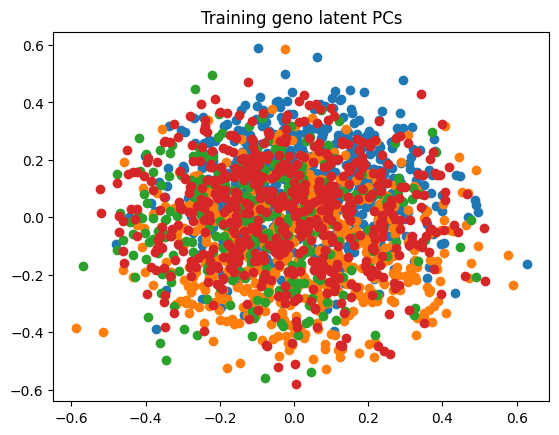

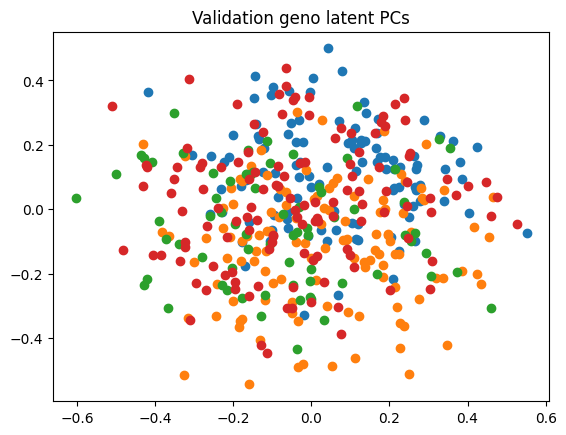

In [ ]:
geno_pca = PCA()
geno_pca.fit(train_geno)
train_geno_pcs = geno_pca.transform(train_geno) 
plt.scatter(train_geno_pcs[train_y == 0][:, 0], train_geno_pcs[train_y == 0][:, 1])
plt.scatter(train_geno_pcs[train_y== 1][:, 0], train_geno_pcs[train_y== 1][:, 1] )
plt.scatter(train_geno_pcs[train_y== 2][:, 0], train_geno_pcs[train_y== 2][:, 1] )
plt.scatter(train_geno_pcs[train_y== 3][:, 0], train_geno_pcs[train_y== 3][:, 1] )
plt.title("Training geno latent PCs")
plt.show()

val_geno_pcs = geno_pca.transform(val_geno)
plt.scatter(val_geno_pcs[val_y == 0][:, 0], val_geno_pcs[val_y == 0][:, 1])
plt.scatter(val_geno_pcs[val_y== 1][:, 0], val_geno_pcs[val_y== 1][:, 1] )
plt.scatter(val_geno_pcs[val_y == 2][:, 0], val_geno_pcs[val_y == 2][:, 1])
plt.scatter(val_geno_pcs[val_y == 3][:, 0],val_geno_pcs[val_y == 3][:, 1])
plt.title("Validation geno latent PCs")
plt.show()

### **Classification**

In [ ]:
LR = 3e-4
gamma = 0.95
classifier = nn.Sequential(multi_model.im_model.feature_extractor, 
                           Squeeze(),
                           SNPEncoder(x_dim = 512, 
                                       fc_dims = [128], 
                                       out_dim = num_classes,
                                       use_bn = True)).to(device)
criterion_ce = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), lr = LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)

In [ ]:
# fit model
NUM_EPOCHS = 100
###### Train Model ######
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val = float("inf")
best_epoch = 0

for epoch in tqdm(range(NUM_EPOCHS)):

    # train 
    train_loss, train_acc = epoch_standard(classifier, criterion_ce, train_loader, epoch, optimizer = optimizer, device = device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # eval 
    val_loss, val_acc = epoch_standard(classifier, criterion_ce, val_loader, epoch, optimizer = None, device = device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    scheduler.step()
    # retain best val
    if best_val > val_losses[-1]:
        print(f"Updating at epoch {epoch}")
        best_val = val_losses[-1]
        best_epoch = epoch
        # save model parameter/state dictionary
        best_model = copy.deepcopy(classifier.state_dict())

# load best weights
print(f"Best epoch at {best_epoch} with {'CrossEntropy'} loss: {best_val}")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 0


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 2


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 3


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 5


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 7


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 19


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 30


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 32


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 57


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Best epoch at 57 with CrossEntropy loss: 0.7251537293195724


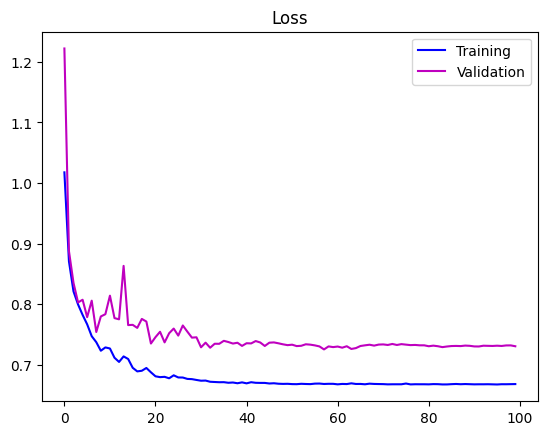

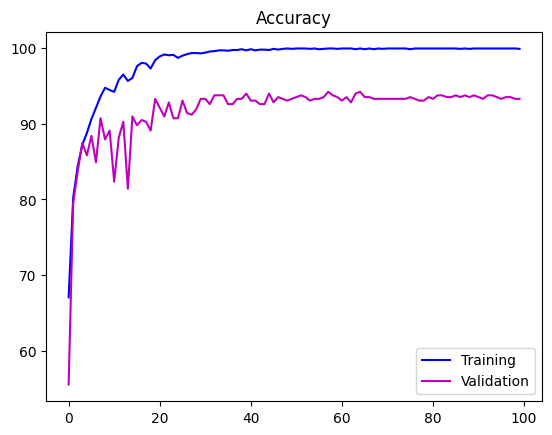

In [ ]:
plt.plot(list(range(NUM_EPOCHS)), train_losses, label='Training', c = 'b')
plt.plot(list(range(NUM_EPOCHS)), val_losses, label='Validation', c = 'm')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(list(range(NUM_EPOCHS)), train_accs, label='Training', c = 'b')
plt.plot(list(range(NUM_EPOCHS)), val_accs, label='Validation', c = 'm')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier.load_state_dict(best_model)
print(epoch_standard(classifier, criterion_ce, test_loader, epoch = 0, device = device))

  0%|          | 0/4 [00:00<?, ?it/s]

(0.7415954768657684, array(93.05556, dtype=float32))


In [ ]:
from sklearn.metrics import confusion_matrix

# per class 

y_pred = []
y_true = []
for im, geno, y in test_loader:
    y = y.type(torch.int64)
    im = im.to(device)
    y_pred += list(classifier(im).max(dim = 1)[1].detach().cpu().numpy())
    y_true += list(y.detach().cpu().numpy())

print(confusion_matrix(y_true, y_pred))

[[120  11   0   0]
 [  3 124   2   3]
 [  0   5  42   2]
 [  2   1   1 116]]


## **Performance**

In [ ]:
# compare no gene w/ standard cnn training
no_gene_resnet = ResnetEncoder(num_channels = 3, 
                  num_classes = num_classes, 
                  weights = None, 
                  out_dim=Z_DIM)

classifier_no_geno = nn.Sequential(
    no_gene_resnet.feature_extractor,
    Squeeze(),
    SNPEncoder(x_dim = 512,  # just an mlp (didnt want to refactor)
            fc_dims = [128], 
            out_dim = num_classes,
            use_bn = True)
).to(device)
optimizer = optim.AdamW(classifier_no_geno.parameters(), lr = LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)
# fit model
NUM_EPOCHS = 100
###### Train Model ######
train_losses_no_geno = []
train_accs_no_geno = []
val_losses_no_geno = []
val_accs_no_geno = []
best_val_no_geno = float("inf")
best_epoch_no_geno = 0

for epoch in tqdm(range(NUM_EPOCHS)):

    # train 
    train_loss, train_acc = epoch_standard(classifier_no_geno, criterion_ce, train_loader, epoch, optimizer = optimizer, device = device)
    train_losses_no_geno.append(train_loss)
    train_accs_no_geno.append(train_acc)

    # eval 
    val_loss, val_acc = epoch_standard(classifier_no_geno, criterion_ce, val_loader, epoch, optimizer = None, device = device)
    val_losses_no_geno.append(val_loss)
    val_accs_no_geno.append(val_acc)
    scheduler.step()

    # retain best val
    if best_val_no_geno > val_losses_no_geno[-1]:
        print(f"Updating at epoch {epoch}")
        best_val_no_geno = val_losses_no_geno[-1]
        best_epoch_no_geno = epoch
        # save model parameter/state dictionary
        best_model_no_geno = copy.deepcopy(classifier_no_geno.state_dict())

# load best weights
print(f"Best epoch at {best_epoch} with {'CrossEntropy'} loss: {best_val}")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 0


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 2


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 3


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 4


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 5


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 6


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 8


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 9


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 14


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 15


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 17


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 20


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Updating at epoch 25


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Best epoch at 57 with CrossEntropy loss: 0.7251537293195724


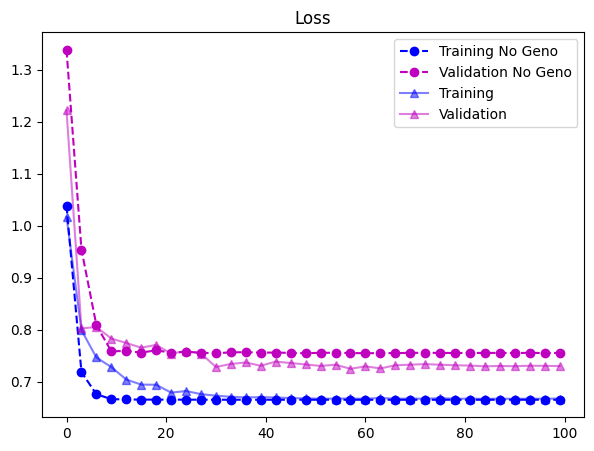

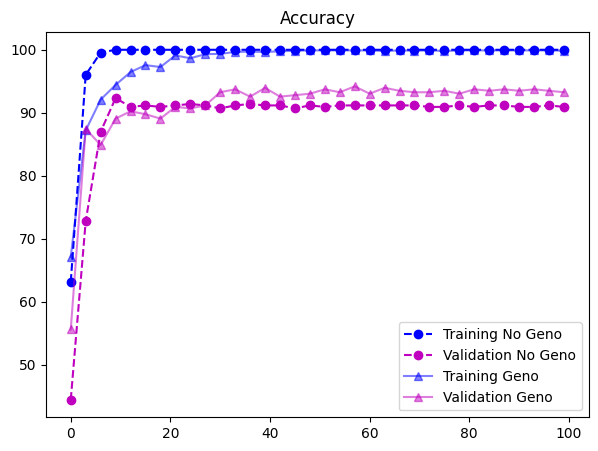

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(list(range(NUM_EPOCHS))[::3], train_losses_no_geno[::3], label='Training No Geno', c = 'b', linestyle='dashed', marker = 'o', alpha = 0.75)
plt.plot(list(range(NUM_EPOCHS))[::3], val_losses_no_geno[::3], label='Validation No Geno', c = 'b', linestyle='dashed', marker = 'o', alpha = 0.75)
plt.plot(list(range(NUM_EPOCHS))[::3], train_losses[::3], label='Training Geno Pre', c = 'm', marker = '^', alpha = 0.75)
plt.plot(list(range(NUM_EPOCHS))[::3], val_losses[::3], label='Validation Geno Pre', c = 'm', marker = '^', alpha = 0.75)
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(list(range(NUM_EPOCHS))[::3], train_accs_no_geno[::3], label='Training No Geno', c = 'b', linestyle='dashed', marker = 'o', alpha = 0.75)
plt.plot(list(range(NUM_EPOCHS))[::3], val_accs_no_geno[::3], label='Validation No Geno', c = 'b', linestyle='dashed', marker = 'o', alpha = 0.75)
plt.plot(list(range(NUM_EPOCHS))[::3], train_accs[::3], label='Training Geno Pre', c = 'm', marker = '^', alpha = 0.75)
plt.plot(list(range(NUM_EPOCHS))[::3], val_accs[::3], label='Validation Geno Pre', c = 'm', marker = '^', alpha = 0.75)
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_no_geno.load_state_dict(best_model_no_geno)
print(epoch_standard(classifier_no_geno, criterion_ce, test_loader, epoch = 0, device = device))
print(epoch_standard(classifier, criterion_ce, test_loader, epoch = 0, device = device))

  0%|          | 0/4 [00:00<?, ?it/s]

(0.7878371477127075, array(88.65741, dtype=float32))


  0%|          | 0/4 [00:00<?, ?it/s]

(0.7415954768657684, array(93.05556, dtype=float32))


In [ ]:
# per class 

y_pred_no_geno = []
y_true_no_geno = []
for im, geno, y in test_loader:
    y = y.type(torch.int64)
    im = im.to(device)
    y_pred_no_geno += list(classifier_no_geno(im).max(dim = 1)[1].detach().cpu().numpy())
    y_true_no_geno += list(y.detach().cpu().numpy())

print("NO GENO:\n", confusion_matrix(y_true_no_geno, y_pred_no_geno), "\n\n", confusion_matrix(y_true_no_geno, y_pred_no_geno, normalize = 'true'))
print("GENO:\n",confusion_matrix(y_true, y_pred), "\n\n", confusion_matrix(y_true, y_pred, normalize = 'true'))

NO GENO:
 [[114  17   0   0]
 [ 14 110   5   3]
 [  1   2  43   3]
 [  0   3   1 116]] 

 [[0.87022901 0.12977099 0.         0.        ]
 [0.10606061 0.83333333 0.03787879 0.02272727]
 [0.02040816 0.04081633 0.87755102 0.06122449]
 [0.         0.025      0.00833333 0.96666667]]
GENO:
 [[120  11   0   0]
 [  3 124   2   3]
 [  0   5  42   2]
 [  2   1   1 116]] 

 [[0.91603053 0.08396947 0.         0.        ]
 [0.02272727 0.93939394 0.01515152 0.02272727]
 [0.         0.10204082 0.85714286 0.04081633]
 [0.01666667 0.00833333 0.00833333 0.96666667]]


## **Interpretability**

In [ ]:
class ImageExplainer(nn.Module):
    def __init__(self, model, ref_img, ref_modes, batch_size, w, device = 'cpu'): 
        """
        Forward pass of Explainer module returns self-supervised contrastive loss of 
        modalities on an image embedding.

        Closely following:
            https://github.com/HealthML/ContIG/blob/main/feature_explanations.py

        Params:
            model -- Multimodal neural network
            ref_img -- Reference image batch (contrastive loss works in batches)
            ref_modes -- Reference modality batch
                ref_modes[i] is a tensor representing the batch of observations for mode i
            batch_size -- Batch size for NTXent Loss
            w -- Weighting for loss
        """
        super().__init__() 
        self.device = device
        self.model = model
        self.model.eval()
        self.model.im_model.eval()
        for mode_model in model.model:
            mode_model.eval()

        with torch.no_grad(): 
            # set reference embeddings
            self.ref_img_embedding = self.model.im_model(ref_img.to(self.device))
            self.ref_modes_embedding = []

            # for each mode
            for i in range(len(ref_modes)):
                self.ref_modes_embedding.append(model.model[i](ref_modes[i]).to(self.device))

        self.loss_fn = NTXentLoss(device, 
                               batch_size, 
                               temperature = 0.07, 
                               alpha_weight = 0.75) # 0.75 weight towards images as in ContIG paper

        self.w = w

        def lf(imgE, embeddings):
            """
            Calculate loss for list of modalitie
            
                imgE -- image embedding
                embeddings -- List of (batch_size, mode features) tensors for each modality
            """
            loss = 0.0
            for modeE in embeddings:
                loss += self.w * self.loss_fn(imgE, modeE)
            return loss 
        
        self.loss = lf

    def set_img_embedding(self, img):
        """
        Image embedding that we want to explain
        """
        with torch.no_grad():
            self.img_embedding = (
                self.model.im_model(img.unsqueeze(0).to(self.device))
            ).to(self.device)

    def forward(self, modes):
        """
        Run the explainer. Returns list of losses for each individual.

            modes -- list of tensors 
                modes[i] is a tensor # individuals to explain x mode i feature dim
        """
        # run w/ modes associated w/ same image
        loss = torch.zeros(len(modes)) # one loss for each individual
        # print(modes.shape)

        # concatenate reference and current embeddings
        img_embedding_mod = torch.cat(
            [
                self.ref_img_embedding,
                self.img_embedding,
            ]
        ).to(self.device)
        # print(img_embedding_mod.shape)
        # print(modes.shape)

        # for each individual
        for i in range(len(modes)):
            # for each mode
            embeddings = []
            for j in range(modes.shape[-1]):
                embeddings.append(
                    torch.cat([
                        self.ref_modes_embedding[j],
                        self.model.model[j](modes[i, :, j].unsqueeze(0)).to(self.device)
                    ])
                )

            loss[i] = self.loss(
                img_embedding_mod,
                embeddings
            )

        return loss


def explain_image(im, modes, explainer, attr_kwargs = dict(), device = 'cpu', use_tqdm = True):
    """
    Explain an image using it's modes
    """
    attr_tests = [] # store attributes
    modes = torch.cat([mode.unsqueeze(-1) for mode in modes], axis = -1)
    print(modes.shape)

    # for each observation
    gen = tqdm(range(len(modes))) if use_tqdm else range(len(modes))
    for i in gen: 
        explainer.set_img_embedding(im[i].to(device))
        attr_test = IntegratedGradients(explainer).attribute(
            modes, **attr_kwargs
        )
        attr_tests.append(attr_test.detach().cpu().double().numpy())

    return attr_tests


#### **Explaining using finetuned contrastive encoder**

In [ ]:
reference_ims = []
reference_genos = []

for im, geno, y in tqdm(train_loader):
    im, geno, y = im.to(device), [geno[0].to(device)], y.to(device).type(torch.int64)
    reference_ims.append(im)
    reference_genos.append(geno[0].unsqueeze(-1))

reference_ims = torch.cat(reference_ims)
reference_genos = torch.cat(reference_genos)
print(reference_ims.shape)
print(reference_genos.shape)


reference_batch = (im[0:512, ...],
                   [geno[0][0:512, ...]])
explainer = ImageExplainer(multi_model, *reference_batch, batch_size = BATCH_SIZE, w = 1, device = device)


# exp_ims = []
# exp_genos = []
# for im, geno, y in tqdm(test_loader):
#     im, geno, y = im.to(device), [geno[0].to(device)], y.to(device).type(torch.int64)
#     exp_ims.append(im)
#     exp_genos.append(geno[0])
# exp_ims = torch.cat(exp_ims)
# exp_genos = [torch.cat(exp_genos)]

# exp_input = (
#     exp_ims,
#     exp_genos
# )

# attr_kwargs = {

# }
# exps = explain_image(
#                     *exp_input,
#                     explainer,
#                     attr_kwargs,
#                     device = device
# )
# print(exps[0].shape) # only one modality

  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([2008, 3, 224, 224])
torch.Size([2008, 500, 1])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([128, 500, 1])


  0%|          | 0/128 [00:00<?, ?it/s]

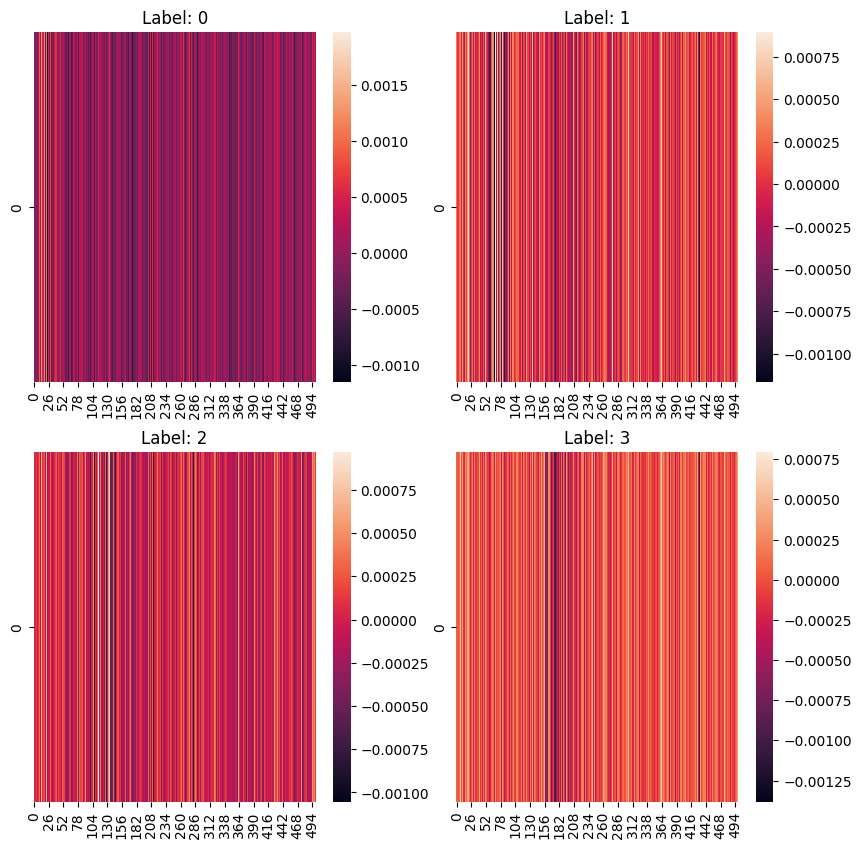

torch.Size([128, 500, 1])


  0%|          | 0/128 [00:00<?, ?it/s]

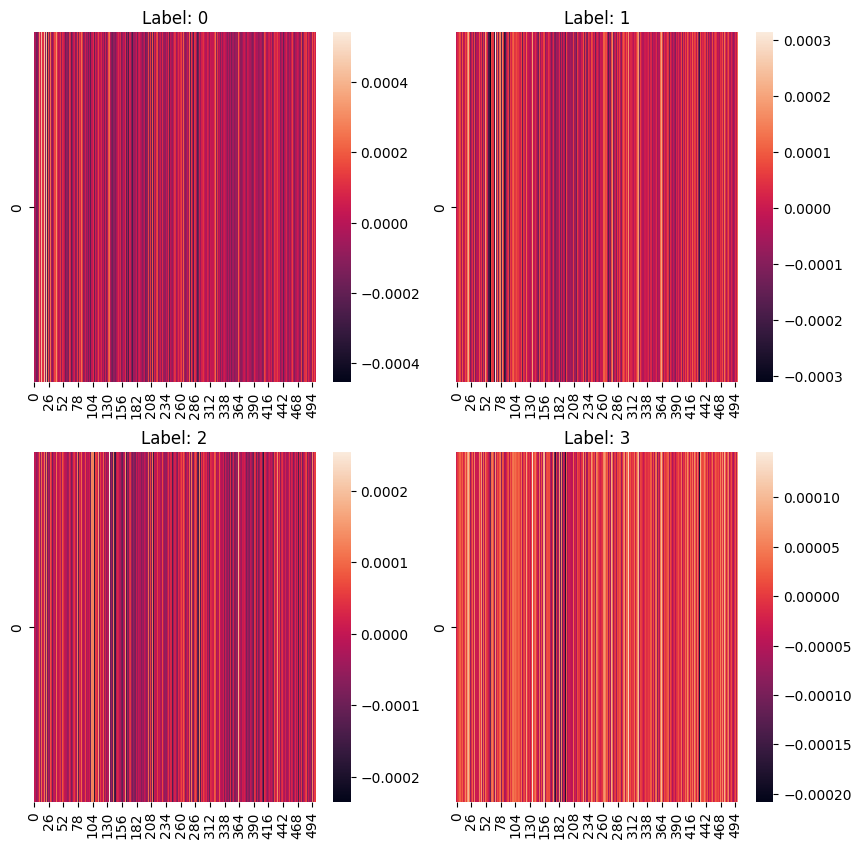

torch.Size([128, 500, 1])


  0%|          | 0/128 [00:00<?, ?it/s]

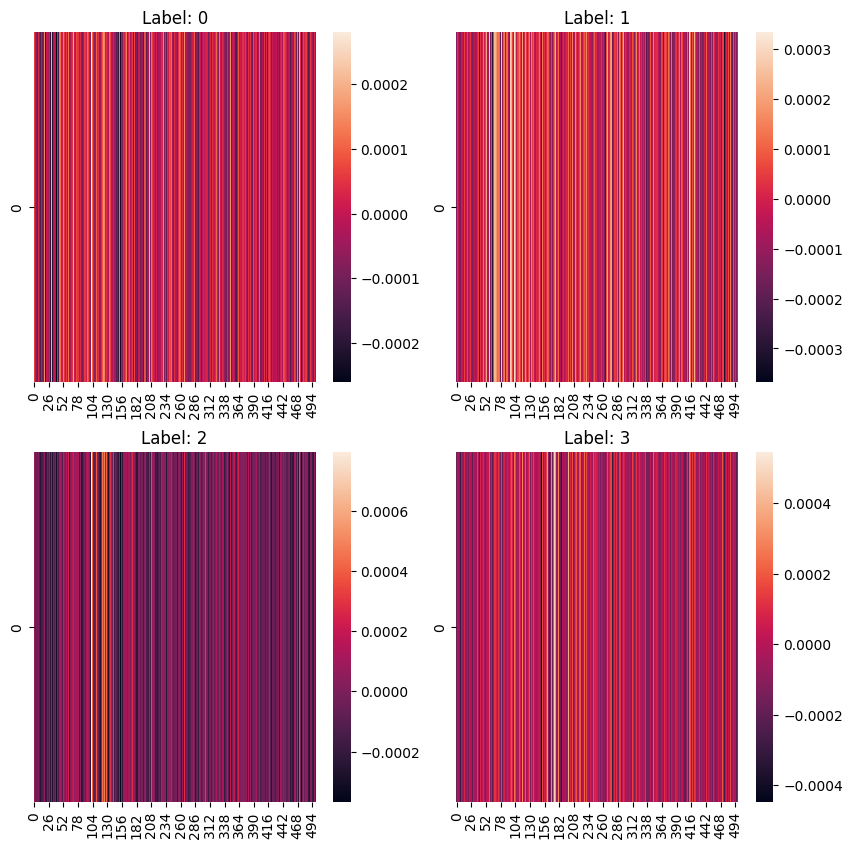

torch.Size([48, 500, 1])


  0%|          | 0/48 [00:00<?, ?it/s]

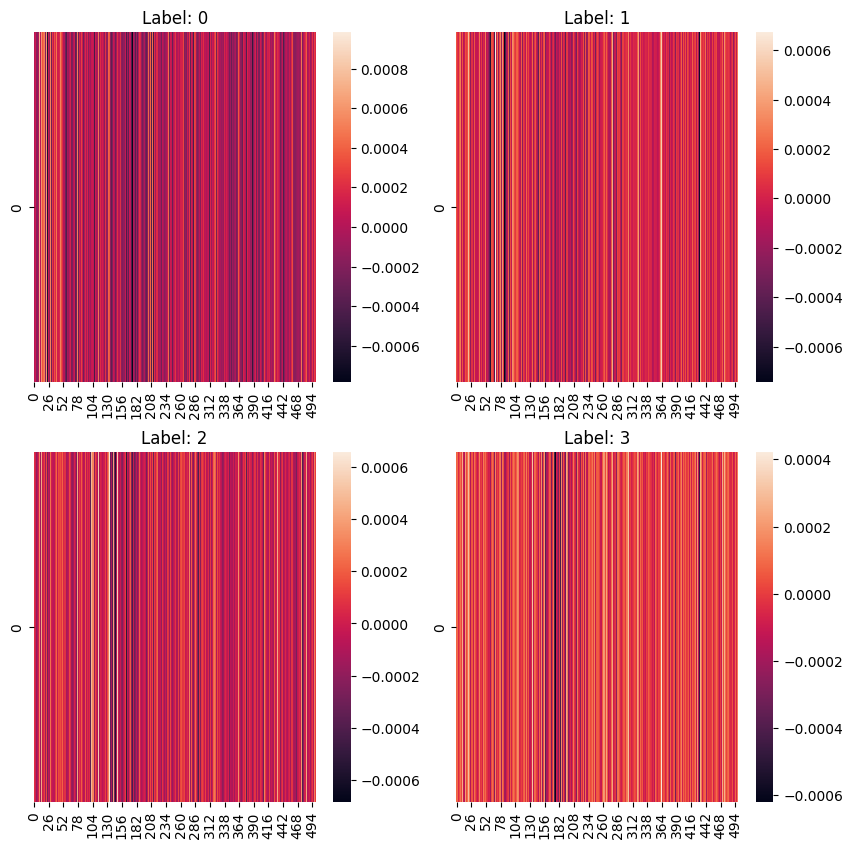

In [ ]:
exps_total = []
y_total = []
for im, geno, y in tqdm(test_loader):
    exp_ims = im.to(device)
    exp_genos = [geno[0].to(device)]

    exp_input = (
        exp_ims,
        exp_genos
    )

    attr_kwargs = {

    }
    exps = explain_image(
                        *exp_input,
                        explainer,
                        attr_kwargs,
                        device = device
    )
    exps_total.append(exps[0])
    y_total.append(y)

    plt.figure(figsize = (10, 10))
    plt.subplot(221)
    sns.heatmap(np.expand_dims(exps[0][(y == 0).squeeze(),..., 0].mean(0), 0))
    plt.title(f"Label: {0}")

    plt.subplot(222)
    sns.heatmap(np.expand_dims(exps[0][(y == 1).squeeze(),..., 0].mean(0), 0))
    plt.title(f"Label: {1}")

    plt.subplot(223)
    sns.heatmap(np.expand_dims(exps[0][(y == 2).squeeze(),..., 0].mean(0), 0))
    plt.title(f"Label: {2}")

    plt.subplot(224)
    sns.heatmap(np.expand_dims(exps[0][(y == 3).squeeze(),..., 0].mean(0), 0))
    plt.title(f"Label: {3}")

    plt.show()


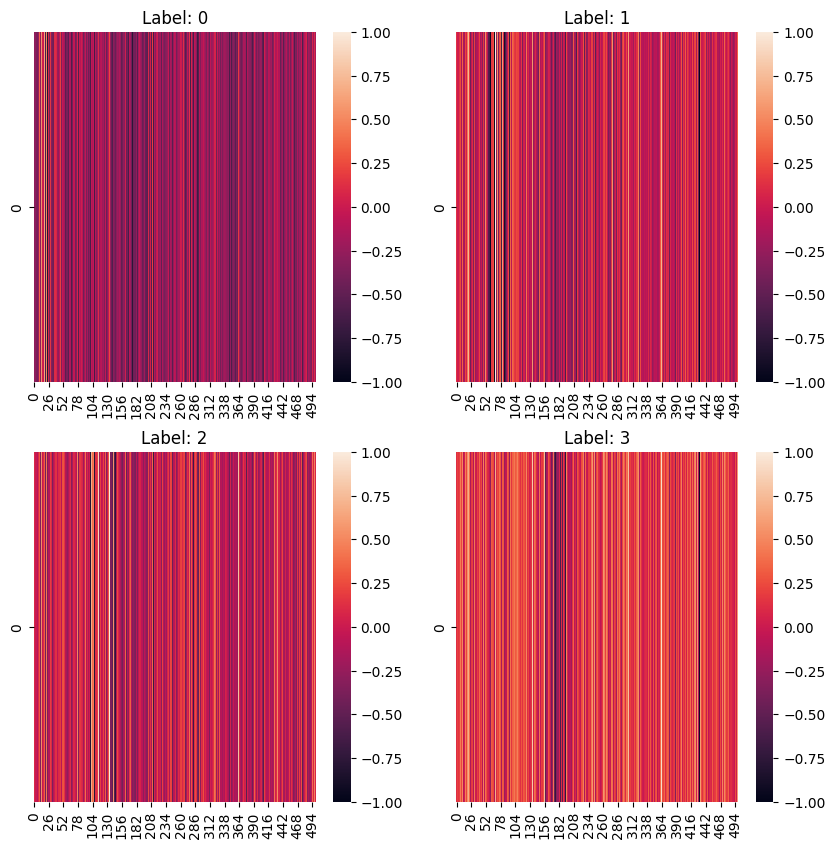

In [ ]:
exps_total_cat = np.concatenate(exps_total, axis = 0)
y_total_cat = np.concatenate(y_total, axis = 0)
snps = ['sim_rs' + str(i) for i in range(500)]

plt.figure(figsize = (10, 10))
plt.subplot(221)
y_mean = exps_total_cat[(y_total_cat == 0).squeeze(),..., 0].mean(0) 
min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
sns.heatmap(np.expand_dims(y_mean, 0))
plt.title(f"Label: {0}")

plt.subplot(222)
y_mean = exps_total_cat[(y_total_cat == 1).squeeze(),..., 0].mean(0) 
min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
sns.heatmap(np.expand_dims(y_mean, 0))
plt.title(f"Label: {1}")

plt.subplot(223)
y_mean = exps_total_cat[(y_total_cat == 2).squeeze(),..., 0].mean(0) 
min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
sns.heatmap(np.expand_dims(y_mean, 0))
plt.title(f"Label: {2}")

plt.subplot(224)
y_mean = exps_total_cat[(y_total_cat == 3).squeeze(),..., 0].mean(0) 
min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
sns.heatmap(np.expand_dims(y_mean, 0))
plt.title(f"Label: {3}")

plt.show()

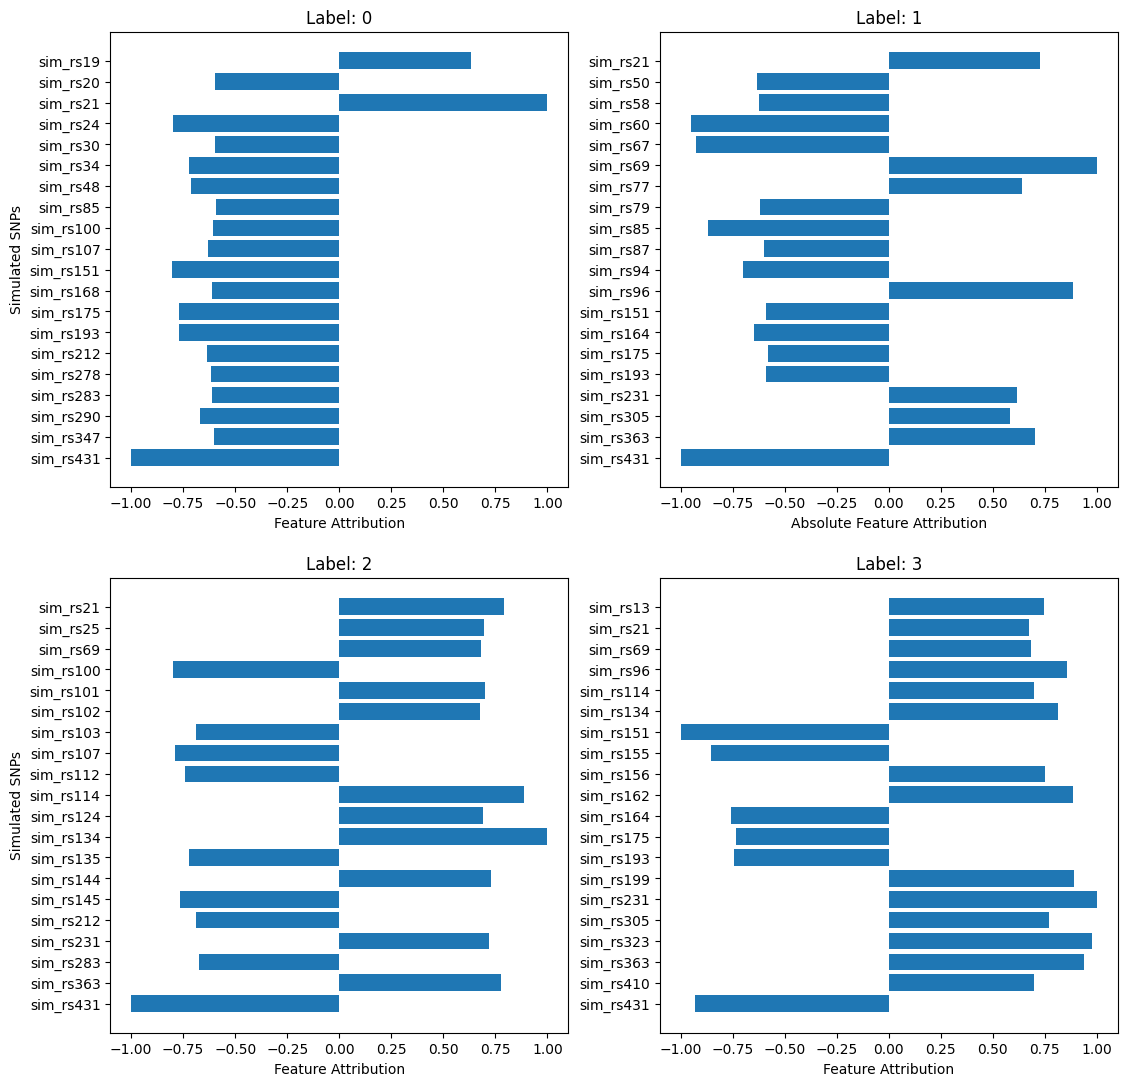

In [ ]:
# top 20 features per label
exps_total_cat = np.concatenate(exps_total, axis = 0)
y_total_cat = np.concatenate(y_total, axis = 0)
snps = np.array(['sim_rs' + str(i) for i in range(500)])
width = 0.8

plt.figure(figsize = (13, 13))
plt.subplot(221)
y_mean = exps_total_cat[(y_total_cat == 0).squeeze(),..., 0].mean(0) 
min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
ind = np.argpartition(np.abs(y_mean), -20)[-20:]
snp_order = np.argsort(ind)[::-1]
plt.barh(snps[ind][snp_order], y_mean[ind][snp_order])
plt.ylabel('Simulated SNPs')
plt.xlabel('Feature Attribution')
plt.title(f"Label: {0}")

plt.subplot(222)
y_mean = exps_total_cat[(y_total_cat == 1).squeeze(),..., 0].mean(0) 
min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
ind = np.argpartition(np.abs(y_mean), -20)[-20:]
snp_order = np.argsort(ind)[::-1]
plt.barh(snps[ind][snp_order], y_mean[ind][snp_order])
plt.xlabel('Absolute Feature Attribution')
plt.title(f"Label: {1}")

plt.subplot(223)
y_mean = exps_total_cat[(y_total_cat == 2).squeeze(),..., 0].mean(0) 
min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
ind = np.argpartition(np.abs(y_mean), -20)[-20:]
snp_order = np.argsort(ind)[::-1]
plt.barh(snps[ind][snp_order], y_mean[ind][snp_order])
plt.ylabel('Simulated SNPs')
plt.xlabel('Feature Attribution')
plt.title(f"Label: {2}")

plt.subplot(224)
y_mean = exps_total_cat[(y_total_cat == 3).squeeze(),..., 0].mean(0) 
min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
ind = np.argpartition(np.abs(y_mean), -20)[-20:]
snp_order = np.argsort(ind)[::-1]
plt.barh(snps[ind][snp_order], y_mean[ind][snp_order])
plt.xlabel('Feature Attribution')
plt.title(f"Label: {3}")

plt.show()

#### **Explaining using from-scratch resnet**

In [ ]:
# multi_model_mod = copy.deepcopy(multi_model) # might not work tho b/c SNP encoder already trained w/ relation to prev im model...
# multi_model_mod.im_model = no_gene_resnet.to(device)
# explainer = ImageExplainer(multi_model_mod, *reference_batch, batch_size = BATCH_SIZE, w = 1, device = device)

In [ ]:
# exps_total = []
# y_total = []
# for im, geno, y in tqdm(test_loader):
#     exp_ims = im.to(device)
#     exp_genos = [geno[0].to(device)]

#     exp_input = (
#         exp_ims,
#         exp_genos
#     )

#     attr_kwargs = {

#     }
#     exps = explain_image(
#                         *exp_input,
#                         explainer,
#                         attr_kwargs,
#                         device = device
#     )
#     exps_total.append(exps[0])
#     y_total.append(y)

#     plt.figure(figsize = (10, 10))
#     plt.subplot(221)
#     sns.heatmap(np.expand_dims(exps[0][(y == 0).squeeze(),..., 0].mean(0), 0))
#     plt.title(f"Label: {0}")

#     plt.subplot(222)
#     sns.heatmap(np.expand_dims(exps[0][(y == 1).squeeze(),..., 0].mean(0), 0))
#     plt.title(f"Label: {1}")

#     plt.subplot(223)
#     sns.heatmap(np.expand_dims(exps[0][(y == 2).squeeze(),..., 0].mean(0), 0))
#     plt.title(f"Label: {2}")

#     plt.subplot(224)
#     sns.heatmap(np.expand_dims(exps[0][(y == 3).squeeze(),..., 0].mean(0), 0))
#     plt.title(f"Label: {3}")

#     plt.show()


In [ ]:
# exps_total_cat = np.concatenate(exps_total, axis = 0)
# y_total_cat = np.concatenate(y_total, axis = 0)

# plt.figure(figsize = (10, 10))
# plt.subplot(221)
# y_mean = exps_total_cat[(y_total_cat == 0).squeeze(),..., 0].mean(0) 
# min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
# max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
# y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
# sns.heatmap(np.expand_dims(y_mean, 0))
# plt.title(f"Label: {0}")

# plt.subplot(222)
# y_mean = exps_total_cat[(y_total_cat == 1).squeeze(),..., 0].mean(0) 
# min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
# max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
# y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
# sns.heatmap(np.expand_dims(y_mean, 0))
# plt.title(f"Label: {1}")

# plt.subplot(223)
# y_mean = exps_total_cat[(y_total_cat == 2).squeeze(),..., 0].mean(0) 
# min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
# max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
# y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
# sns.heatmap(np.expand_dims(y_mean, 0))
# plt.title(f"Label: {2}")

# plt.subplot(224)
# y_mean = exps_total_cat[(y_total_cat == 3).squeeze(),..., 0].mean(0) 
# min_y = y_mean.min()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
# max_y = y_mean.max()#.reshape(exps_total_cat.shape[0], 1, exps_total_cat.shape[2])
# y_mean = 2 * (y_mean - min_y)/(max_y - min_y) - 1 # scale
# sns.heatmap(np.expand_dims(y_mean, 0))
# plt.title(f"Label: {3}")

# plt.show()